**Imports**

In [0]:
!pip install numpy==1.16.1
import numpy as np
import sys
import io
import base64
import cv2
import numpy as np
import skimage
import cv2
import os
import numpy as np
import pandas as pd
import skimage

import pandas as pd
from os import listdir
from os.path import isfile, join
#from IPython.display import Video , YouTubeVideo
import numpy as np
from shutil import copy
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import sys
#import ipdb
import time
import cv2
from keras.preprocessing import sequence
import matplotlib.pyplot as plt



Using TensorFlow backend.


In [0]:
from google.colab import drive
drive.mount('/content/gdrive' , force_remount=True)

Mounted at /content/gdrive


# CSV Conversion (old)

In [0]:
file_name = '/content/gdrive/My Drive/Graduation Project/Datasets/vicomdataset/MSR_VDCOM.csv'
feature_path = '/content/gdrive/My Drive/Graduation Project/Datasets/vicomdataset/features'
seed = 0

In [0]:
################################################################################
#                                                                              #
#          filter MSVD descriptions to get only english descritpion            # 
#                                                                              #
################################################################################

def get_english_data(file_name, feature_path):
  
  data = pd.read_csv(file_name)
  data = data[data['Language'] == 'English']
  data = data.drop_duplicates(subset=['VideoID' , 'Start' , 'End'])
  
  # the result contains start and end values of the csv file.
  feature_files = [f[:f.find('.')] for f in listdir(feature_path) if isfile(join(feature_path, f))]
  
  #features_files_df = pd.DataFrame(np.array([feature_files]), columns=['file_names'])
  
  data['concatenated_file_name'] = data.apply(lambda row: row['VideoID'] + 
                                   ( '_' + str(int(row['Start'])) if int(row['Start']) != -1 else '') +
                                   ( '_' + str(int(row['End'])) if int(row['End']) != -1 else ''), axis=1)
  
  #result = data.set_index('concatenated_file_name').join(features_files_df.set_index('file_names'))
  
  result = data[data['concatenated_file_name'].isin(feature_files)]
  
  return result

In [0]:
def copyFile(row, src, dest):
  try :
    copy(src +'/' +row['concatenated_file_name'] + '.avi.npy', dest)
  except :
    print("File : " + row['concatenated_file_name'] + " not found")

In [0]:
def get_random_mask(train_size, english_data):
  np.random.seed(seed)
  return np.random.choice([0, 1], size=(len(english_data),), p=[train_size, 1-train_size]) < 1  

In [0]:
display(get_random_mask(0.8, [1,2,3,4,5,6,7,8,9,10]))

array([ True,  True,  True,  True,  True,  True,  True, False, False,
        True])

In [0]:
def split_english_data(videos_path, train_path, test_path, english_data, train_size):
  
  # get mask.
  msk = get_random_mask(train_size, english_data)
  
  # split data.
  train = english_data[msk]
  test = english_data[~msk]
  
  # copy data to specific files.
  train.apply(lambda row: copyFile(row, videos_path, train_path), axis=1)
  test.apply(lambda row: copyFile(row, videos_path, test_path), axis=1)
  return [train, test]

In [0]:
data = get_english_data(file_name, feature_path)

In [0]:
data.head()

,Unnamed: 0,VideoID,Start,End,WorkerID,Source,AnnotationTime,Language,Description,concatenated_file_name
0,1965,00260230,-1,-1,-1,clean,-1,English,DURING THE SHOW JESSE AND I BECAME REALLY CLOSE.,00260230
1,1123,00260519,-1,-1,-1,clean,-1,English,Reporter: BEAR MADE SEVERAL STOPS ALONG THE WAY.,00260519
3,1402,00260034,-1,-1,-1,clean,-1,English,"""BEASTS OF THE SOUTHERN WILD"" IS FILMED IN NEW...",00260034
4,40582,77iDIp40m9E,159,181,554590,unverified,57,English,A chimpanzee kickboxes with a human.,77iDIp40m9E_159_181
5,88842,2I20ZTFHheg,96,104,525230,unverified,186,English,gingher 7-inch dressmakers shears video,2I20ZTFHheg_96_104


In [0]:
!mkdir train
!mkdir test

In [0]:
split_english_data(feature_path,'/content/train','/content/test',data,0.8)

[      Unnamed: 0      VideoID  Start  End  WorkerID      Source  \
 0           1965     00260230     -1   -1        -1       clean   
 1           1123     00260519     -1   -1        -1       clean   
 3           1402     00260034     -1   -1        -1       clean   
 4          40582  77iDIp40m9E    159  181    554590  unverified   
 5          88842  2I20ZTFHheg     96  104    525230  unverified   
 6            522     00260752     -1   -1        -1       clean   
 7          43403  AX38yo7Wuws     81   91    318570  unverified   
 10           627     00262744     -1   -1        -1       clean   
 11         37419  JntMAcTlOF0     50   70    638934  unverified   
 12          3077  XzCcRzEa83U      1    8    678142  unverified   
 13        105983  qeKX-N1nKiM      0    5    807872       clean   
 15         29131  gtIz1u8g1F0      3   13    275759       clean   
 16         16900  fX5G_JwPlLo    640  660    524008  unverified   
 17           282     00261634     -1   -1      

In [0]:
train_file_names = os.listdir('/content/train')
test_file_names = os.listdir('/content/test')
rgb_file_names = os.listdir(feature_path)

print("train-size : ", len(train_file_names))
print("test-size : ", len(test_file_names))
print("rgb-feats-size : ", len(rgb_file_names))

for f in train_file_names:
  if f in test_file_names:
    print(f)

train-size :  1519
test-size :  418
rgb-feats-size :  1970


In [0]:
# copy train test split tot drive to prevent running code after every reset
!rm -r '/content/gdrive/My Drive/Graduation Project/Sequence 2 Vector/train'
!rm -r '/content/gdrive/My Drive/Graduation Project/Sequence 2 Vector/test'
!cp -r '/content/train' '/content/gdrive/My Drive/Graduation Project/Sequence 2 Vector/'
!cp -r '/content/test' '/content/gdrive/My Drive/Graduation Project/Sequence 2 Vector/'

# 

# Model

In [0]:
!mkdir '/content/gdrive/My Drive/Graduation Project/Sequence 2 Vector/models'
!mkdir '/content/gdrive/My Drive/Graduation Project/Sequence 2 Vector/data'
!mkdir '/content/gdrive/My Drive/Graduation Project/Sequence 2 Vector/data/wordtoix'
!mkdir '/content/gdrive/My Drive/Graduation Project/Sequence 2 Vector/data/ixtoword'
!mkdir '/content/gdrive/My Drive/Graduation Project/Sequence 2 Vector/data/bias_init_vector'
!mkdir '/content/gdrive/My Drive/Graduation Project/Sequence 2 Vector/loss_imgs'

mkdir: cannot create directory ‘/content/gdrive/My Drive/Graduation Project/Sequence 2 Vector/models’: File exists
mkdir: cannot create directory ‘/content/gdrive/My Drive/Graduation Project/Sequence 2 Vector/data’: File exists


In [0]:
#=====================================================================================
# Global Parameters
#=====================================================================================
video_train_feat_path = '/content/gdrive/My Drive/Graduation Project/Different Feature Extractor Models/graduationFeatures/msvd1/shortPreprocessWithAmrFix/VGG-16(4096)/trainVal'
video_test_feat_path = '/content/gdrive/My Drive/Graduation Project/Different Feature Extractor Models/graduationFeatures/msvd1/shortPreprocessWithAmrFix/VGG-16(4096)/test'

video_train_data_path = '/content/gdrive/My Drive/Graduation Project/Datasets/MSVD old version/MSR Video Description Corpus/MSR Video Description Corpus.csv'
video_test_data_path = '/content/gdrive/My Drive/Graduation Project/Datasets/MSVD old version/MSR Video Description Corpus/MSR Video Description Corpus.csv'

model_path = '/content/gdrive/My Drive/Graduation Project/Sequence 2 Vector/models/vgg_extraction_old_msvd'

#=======================================================================================
# Train Parameters
#=======================================================================================
dim_image = 4096
dim_hidden = 1000

n_video_lstm_step = 80
n_caption_lstm_step = 20
n_frame_step = 80

n_epochs = 1000
batch_size = 100
learning_rate = 0.001

In [0]:
class Video_Caption_Generator():
    def __init__(self, dim_image, n_words, dim_hidden, batch_size, n_lstm_steps, n_video_lstm_step, n_caption_lstm_step, bias_init_vector=None):
        self.dim_image = dim_image
        self.n_words = n_words
        self.dim_hidden = dim_hidden
        self.batch_size = batch_size
        self.n_lstm_steps = n_lstm_steps
        self.n_video_lstm_step=n_video_lstm_step
        self.n_caption_lstm_step=n_caption_lstm_step

        self.Wemb = tf.Variable(tf.random_uniform([n_words, dim_hidden], -0.1, 0.1), name='Wemb')
            #self.bemb = tf.Variable(tf.zeros([dim_hidden]), name='bemb')

        self.lstm1 = tf.nn.rnn_cell.BasicLSTMCell(dim_hidden, state_is_tuple=False)
        self.lstm2 = tf.nn.rnn_cell.BasicLSTMCell(dim_hidden, state_is_tuple=False)

        self.encode_image_W = tf.Variable( tf.random_uniform([dim_image, dim_hidden], -0.1, 0.1), name='encode_image_W')
        self.encode_image_b = tf.Variable( tf.zeros([dim_hidden]), name='encode_image_b')

        self.embed_word_W = tf.Variable(tf.random_uniform([dim_hidden, n_words], -0.1,0.1), name='embed_word_W')
        if bias_init_vector is not None:
            self.embed_word_b = tf.Variable(bias_init_vector.astype(np.float32), name='embed_word_b')
        else:
            self.embed_word_b = tf.Variable(tf.zeros([n_words]), name='embed_word_b')

    def build_model(self):
      
        video = tf.placeholder(tf.float32, [self.batch_size, self.n_video_lstm_step, self.dim_image])
        video_mask = tf.placeholder(tf.float32, [self.batch_size, self.n_video_lstm_step])

        caption = tf.placeholder(tf.int32, [self.batch_size, self.n_caption_lstm_step+1])
        caption_mask = tf.placeholder(tf.float32, [self.batch_size, self.n_caption_lstm_step+1])

        video_flat = tf.reshape(video, [-1, self.dim_image])
        image_emb = tf.nn.xw_plus_b( video_flat, self.encode_image_W, self.encode_image_b ) # (batch_size*n_lstm_steps, dim_hidden)
        image_emb = tf.reshape(image_emb, [self.batch_size, self.n_lstm_steps, self.dim_hidden])

        state1 = tf.zeros([self.batch_size, self.lstm1.state_size])
        state2 = tf.zeros([self.batch_size, self.lstm2.state_size])
        padding = tf.zeros([self.batch_size, self.dim_hidden])

        probs = []
        loss = 0.0

        ##############################  Encoding Stage ##################################
        with tf.variable_scope("Encoding") as scope:  
          for i in range(0, self.n_video_lstm_step):
              if i > 0:
                  scope.reuse_variables()

              with tf.variable_scope("LSTM1"):
                  output1, state1 = self.lstm1(image_emb[:,i,:], state1)
                  
              with tf.variable_scope("LSTM2"):
                  output2, state2 = self.lstm2(tf.concat([padding, output1], 1), state2)

        ############################# Decoding Stage ######################################
        with tf.variable_scope("Decoding") as scope:  
          for i in range(0, self.n_caption_lstm_step): ## Phase 2 => only generate captions
              #if i == 0:
              #    current_embed = tf.zeros([self.batch_size, self.dim_hidden])
              #else:
              current_embed = tf.nn.embedding_lookup(self.Wemb, caption[:, i])

              scope.reuse_variables()

              with tf.variable_scope("LSTM1"):
                  output1, state1 = self.lstm1(padding, state1)

              with tf.variable_scope("LSTM2"):
                  output2, state2 = self.lstm2(tf.concat([current_embed, output1], 1), state2)

              labels = tf.expand_dims(caption[:, i+1], 1)
              indices = tf.expand_dims(tf.range(0, self.batch_size, 1), 1)
              concated = tf.concat([indices, labels],1)
              onehot_labels = tf.sparse_to_dense(concated, tf.stack([self.batch_size, self.n_words]), 1.0, 0.0)

              logit_words = tf.nn.xw_plus_b(output2, self.embed_word_W, self.embed_word_b)
              cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logit_words, labels=onehot_labels)
              cross_entropy = cross_entropy * caption_mask[:,i]
              probs.append(logit_words)

              current_loss = tf.reduce_sum(cross_entropy)/self.batch_size
              loss = loss + current_loss

        return loss, video, video_mask, caption, caption_mask, probs


    def build_generator(self):
        video = tf.placeholder(tf.float32, [1, self.n_video_lstm_step, self.dim_image])
        video_mask = tf.placeholder(tf.float32, [1, self.n_video_lstm_step])

        video_flat = tf.reshape(video, [-1, self.dim_image])
        image_emb = tf.nn.xw_plus_b(video_flat, self.encode_image_W, self.encode_image_b)
        image_emb = tf.reshape(image_emb, [1, self.n_video_lstm_step, self.dim_hidden])

        state1 = tf.zeros([1, self.lstm1.state_size])
        state2 = tf.zeros([1, self.lstm2.state_size])
        padding = tf.zeros([1, self.dim_hidden])

        generated_words = []

        probs = []
        embeds = []

        ##############################  Encoding Stage ##################################
        with tf.variable_scope("Encoding") as scope:  
          for i in range(0, self.n_video_lstm_step):
              if i > 0:
                  scope.reuse_variables()

              with tf.variable_scope("LSTM1"):
                  output1, state1 = self.lstm1(image_emb[:, i, :], state1)

              with tf.variable_scope("LSTM2"):
                  output2, state2 = self.lstm2(tf.concat([padding, output1], 1), state2)
       
        ##############################  Decoding Stage ##################################
        with tf.variable_scope("Decoding") as scope:  
          for i in range(0, self.n_caption_lstm_step):
              scope.reuse_variables()

              if i == 0:
                  current_embed = tf.nn.embedding_lookup(self.Wemb, tf.ones([1], dtype=tf.int64))

              with tf.variable_scope("LSTM1"):
                  output1, state1 = self.lstm1(padding, state1)

              with tf.variable_scope("LSTM2"):
                  output2, state2 = self.lstm2(tf.concat([current_embed, output1], 1), state2)

              logit_words = tf.nn.xw_plus_b( output2, self.embed_word_W, self.embed_word_b)
              max_prob_index = tf.argmax(logit_words, 1)[0]
              generated_words.append(max_prob_index)
              probs.append(logit_words)

              current_embed = tf.nn.embedding_lookup(self.Wemb, max_prob_index)
              current_embed = tf.expand_dims(current_embed, 0)

              embeds.append(current_embed)

        return video, video_mask, generated_words, probs, embeds

In [0]:
def get_video_train_data(video_data_path, video_feat_path):
    video_data = pd.read_csv(video_data_path, sep=',')
    video_data = video_data[video_data['Language'] == 'English']
    video_data['video_path'] = video_data.apply(lambda row: row['VideoID'] + 
                                   ( '_' + str(int(row['Start'])) if int(row['Start']) != -1 else '') +
                                   ( '_' + str(int(row['End'])) if int(row['End']) != -1 else '') +'.npy', axis=1)
    video_data['video_path'] = video_data['video_path'].map(lambda x: os.path.join(video_feat_path, x))
    video_data = video_data[video_data['video_path'].map(lambda x: os.path.exists( x ))]
    video_data = video_data[video_data['Description'].map(lambda x: isinstance(x, str))]
    
    unique_filenames = sorted(video_data['video_path'].unique())
    train_data = video_data[video_data['video_path'].map(lambda x: x in unique_filenames)]
    
    return train_data

In [0]:
print("\n","++++"*50,"\n")

train_csv = get_video_train_data(video_train_data_path , video_train_feat_path)

display(train_csv.head())

print("\n","++++"*50,"\n")

print("train videos : {} video".format(train_csv.shape[0]))

print("\n","++++"*50,"\n")




 ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 



,VideoID,Start,End,WorkerID,Source,AnnotationTime,Language,Description,video_path
18,mv89psg6zh4,33,46,682611,clean,66,English,A bird in a sink keeps getting under the runni...,/content/gdrive/My Drive/Graduation Project/Di...
19,mv89psg6zh4,33,46,760882,clean,16,English,A bird is bathing in a sink.,/content/gdrive/My Drive/Graduation Project/Di...
20,mv89psg6zh4,33,46,878566,clean,76,English,A bird is splashing around under a running fau...,/content/gdrive/My Drive/Graduation Project/Di...
21,mv89psg6zh4,33,46,707318,clean,14,English,A bird is bathing in a sink.,/content/gdrive/My Drive/Graduation Project/Di...
22,mv89psg6zh4,33,46,135621,clean,58,English,A bird is standing in a sink drinking water th...,/content/gdrive/My Drive/Graduation Project/Di...



 ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 

train videos : 64644 video

 ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 



In [0]:
def get_video_test_data(video_data_path, video_feat_path):
    video_data = pd.read_csv(video_data_path, sep=',')
    video_data = video_data[video_data['Language'] == 'English']
    video_data['video_path'] = video_data.apply(lambda row: row['VideoID'] + 
                                   ( '_' + str(int(row['Start'])) if int(row['Start']) != -1 else '') +
                                   ( '_' + str(int(row['End'])) if int(row['End']) != -1 else '')+'.npy', axis=1)
    video_data['video_path'] = video_data['video_path'].map(lambda x: os.path.join(video_feat_path, x))
    video_data = video_data[video_data['video_path'].map(lambda x: os.path.exists( x ))]
    video_data = video_data[video_data['Description'].map(lambda x: isinstance(x, str))]

    unique_filenames = sorted(video_data['video_path'].unique())
    test_data = video_data[video_data['video_path'].map(lambda x: x in unique_filenames)]
    
    return test_data

In [0]:
test_csv = get_video_test_data(video_test_data_path , video_test_feat_path)

display(test_csv.head())

print("\n","++++"*50,"\n")

print("test videos : {} video".format(test_csv.shape[0]))

print("\n","++++"*50,"\n")

,VideoID,Start,End,WorkerID,Source,AnnotationTime,Language,Description,video_path
56,ZbzDGXEwtGc,6,15,550906,clean,24,English,a plane flying in the sky,/content/gdrive/My Drive/Graduation Project/Di...
57,ZbzDGXEwtGc,6,15,164462,clean,42,English,A commercial plane flying.,/content/gdrive/My Drive/Graduation Project/Di...
58,ZbzDGXEwtGc,6,15,155632,clean,51,English,A jet is flying.,/content/gdrive/My Drive/Graduation Project/Di...
59,ZbzDGXEwtGc,6,15,617730,clean,27,English,A large jet is flying through the sky.,/content/gdrive/My Drive/Graduation Project/Di...
60,ZbzDGXEwtGc,6,15,297776,clean,28,English,A passenger plane flies through the air.,/content/gdrive/My Drive/Graduation Project/Di...



 ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 

test videos : 16194 video

 ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 



In [0]:
def preProBuildWordVocab(sentence_iterator, word_count_threshold=3):
    # borrowed this function from NeuralTalk
    print ('preprocessing word counts and creating vocab based on word count threshold %d' % (word_count_threshold))
    word_counts = {}
    nsents = 0
    for sent in sentence_iterator:
        nsents += 1
        for w in sent.lower().split(' '):
           word_counts[w] = word_counts.get(w, 0) + 1
    vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
    print ('filtered words from %d to %d' % (len(word_counts), len(vocab)))

    ixtoword = {}
    ixtoword[0] = '<pad>'
    ixtoword[1] = '<bos>'
    ixtoword[2] = '<eos>'
    ixtoword[3] = '<unk>'

    wordtoix = {}
    wordtoix['<pad>'] = 0
    wordtoix['<bos>'] = 1
    wordtoix['<eos>'] = 2
    wordtoix['<unk>'] = 3

    for idx, w in enumerate(vocab):
        wordtoix[w] = idx+4
        ixtoword[idx+4] = w

    word_counts['<pad>'] = nsents
    word_counts['<bos>'] = nsents
    word_counts['<eos>'] = nsents
    word_counts['<unk>'] = nsents

    bias_init_vector = np.array([1.0 * word_counts[ ixtoword[i] ] for i in ixtoword])
    bias_init_vector /= np.sum(bias_init_vector) # normalize to frequencies
    bias_init_vector = np.log(bias_init_vector)
    bias_init_vector -= np.max(bias_init_vector) # shift to nice numeric range

    return wordtoix, ixtoword, bias_init_vector

In [0]:
#######################################
# please set this to last check point #
# please please please please please  #
# don't run before checking           #
#######################################
epoch_start = 420

In [0]:
def train():
  
    train_data = get_video_train_data(video_train_data_path, video_train_feat_path)
    train_captions = train_data['Description'].values

    # test_data = get_video_test_data(video_test_data_path, video_test_feat_path)
    # test_captions = test_data['Description'].values
    
#     captions_list = list(train_captions) + list(test_captions)
    captions_list = list(train_captions)
    captions = np.asarray(captions_list, dtype=np.object)

    captions = map(lambda x: x.replace('.', ''), captions)
    captions = map(lambda x: x.replace(',', ''), captions)
    captions = map(lambda x: x.replace('"', ''), captions)
    captions = map(lambda x: x.replace('\n', ''), captions)
    captions = map(lambda x: x.replace('?', ''), captions)
    captions = map(lambda x: x.replace('!', ''), captions)
    captions = map(lambda x: x.replace('\\', ''), captions)
    captions = map(lambda x: x.replace('/', ''), captions)

    wordtoix, ixtoword, bias_init_vector = preProBuildWordVocab(captions, word_count_threshold=3)
    
    np.save("/content/gdrive/My Drive/Graduation Project/Sequence 2 Vector/data/vgg_extraction_old_msvd/wordtoix", wordtoix)
    np.save('/content/gdrive/My Drive/Graduation Project/Sequence 2 Vector/data/vgg_extraction_old_msvd/ixtoword', ixtoword)
    np.save("/content/gdrive/My Drive/Graduation Project/Sequence 2 Vector/data/vgg_extraction_old_msvd/bias_init_vector", bias_init_vector)

    model = Video_Caption_Generator(
            dim_image=dim_image,
            n_words=len(wordtoix),
            dim_hidden=dim_hidden,
            batch_size=batch_size,
            n_lstm_steps=n_frame_step,
            n_video_lstm_step=n_video_lstm_step,
            n_caption_lstm_step=n_caption_lstm_step,
            bias_init_vector=bias_init_vector)

    tf_loss, tf_video, tf_video_mask, tf_caption, tf_caption_mask, tf_probs = model.build_model()
    sess = tf.InteractiveSession()
    
    # my tensorflow version is 0.12.1, I write the saver with version 1.0
    saver = tf.train.Saver(max_to_keep=10)
    train_op = tf.train.AdamOptimizer(learning_rate).minimize(tf_loss)
    tf.global_variables_initializer().run()

    ########################################################################################
    ## use this to resume model from last check point 
    new_saver = tf.train.Saver()
    new_saver = tf.train.import_meta_graph('/content/gdrive/My Drive/Graduation Project/Sequence 2 Vector/models/vgg_extraction_old_msvd/model-420.meta')
    new_saver.restore(sess, tf.train.latest_checkpoint('/content/gdrive/My Drive/Graduation Project/Sequence 2 Vector/models/vgg_extraction_old_msvd/'))
    ########################################################################################

    loss_fd = open('loss.txt', 'w')
    loss_to_draw = []
    
    prob = 1
    prob_it = 1
    repeat_epochs = 20
      
    for epoch in range(epoch_start, n_epochs):
        loss_to_draw_epoch = []

        index = list(train_data.index)
        np.random.shuffle(index)
        train_data = train_data.loc[index]

        current_train_data = train_data.groupby('video_path').apply(lambda x: x.iloc[np.random.choice(len(x))])
        current_train_data = current_train_data.reset_index(drop=True)
        
        #current_train_data = train_data.sample(frac=1).reset_index(drop=True)
        #display(current_train_data)
        
        prob -= 0.3 / repeat_epochs
        prob_it += 1 

        if prob_it == repeat_epochs:
          prob_it = 1
          prob = 1

        for start, end in zip(
                range(0, len(current_train_data), batch_size),
                range(batch_size, len(current_train_data), batch_size)):

            start_time = time.time()

            current_batch = current_train_data[start:end]
            current_videos = current_batch['video_path'].values

            current_feats = np.zeros((batch_size, n_video_lstm_step, dim_image))
            current_feats_vals = list(map(lambda vid: np.load(vid), current_videos))

            current_video_masks = np.zeros((batch_size, n_video_lstm_step))

            for ind,feat in enumerate(current_feats_vals):
                ####### drop out features #############################
                dropped_f = feat * np.random.binomial(1,  prob , size=feat.shape)              
                current_feats[ind][:len(current_feats_vals[ind])] = dropped_f
                #######################################################
                current_video_masks[ind][:len(current_feats_vals[ind])] = 1

            current_captions = current_batch['Description'].values
            current_captions = map(lambda x: '<bos> ' + x, current_captions)
            current_captions = map(lambda x: x.replace('.', ''), current_captions)
            current_captions = map(lambda x: x.replace(',', ''), current_captions)
            current_captions = map(lambda x: x.replace('"', ''), current_captions)
            current_captions = map(lambda x: x.replace('\n', ''), current_captions)
            current_captions = map(lambda x: x.replace('?', ''), current_captions)
            current_captions = map(lambda x: x.replace('!', ''), current_captions)
            current_captions = map(lambda x: x.replace('\\', ''), current_captions)
            current_captions = list(map(lambda x: x.replace('/', ''), current_captions))

            for idx, each_cap in enumerate(current_captions):
                word = each_cap.lower().split(' ')
                if len(word) < n_caption_lstm_step:
                    current_captions[idx] = current_captions[idx] + ' <eos>'
                else:
                    new_word = ''
                    for i in range(n_caption_lstm_step-1):
                        new_word = new_word + word[i] + ' '
                    current_captions[idx] = new_word + '<eos>'

            current_caption_ind = []
            for cap in current_captions:
                current_word_ind = []
                for word in cap.lower().split(' '):
                    if word in wordtoix:
                        current_word_ind.append(wordtoix[word])
                    else:
                        current_word_ind.append(wordtoix['<unk>'])
                current_caption_ind.append(current_word_ind)

            current_caption_matrix = sequence.pad_sequences(current_caption_ind, padding='post', maxlen=n_caption_lstm_step)
            current_caption_matrix = np.hstack( [current_caption_matrix, np.zeros( [len(current_caption_matrix), 1] ) ] ).astype(int)
            current_caption_masks = np.zeros( (current_caption_matrix.shape[0], current_caption_matrix.shape[1]) )
            nonzeros = np.array( list(map(lambda x: (x != 0).sum() + 1, current_caption_matrix )) )

            for ind, row in enumerate(current_caption_masks):
                row[:nonzeros[ind]] = 1

            probs_val = sess.run(tf_probs, feed_dict={
                tf_video:current_feats,
                tf_caption: current_caption_matrix
                })

            _, loss_val = sess.run(
                    [train_op, tf_loss],
                    feed_dict={
                        tf_video: current_feats,
                        tf_video_mask : current_video_masks,
                        tf_caption: current_caption_matrix,
                        tf_caption_mask: current_caption_masks
                        })
            loss_to_draw_epoch.append(loss_val)

            print ('idx: ', start, " Epoch: ", epoch, " loss: ", loss_val, ' Elapsed time: ', str((time.time() - start_time)))
            loss_fd.write('epoch ' + str(epoch) + ' loss ' + str(loss_val) + '\n')
                
        if np.mod(epoch, 10) == 0:
          loss_to_draw.append(np.mean(loss_to_draw_epoch))
          plt_save_dir = "/content/gdrive/My Drive/Graduation Project/Sequence 2 Vector/loss_imgs/vgg_extraction_old_msvd"
          plt_save_img_name = str(epoch) + '.png'
          plt.plot(range(len(loss_to_draw)), loss_to_draw, color='g')
          plt.grid(True)
          plt.savefig(os.path.join(plt_save_dir, plt_save_img_name))

        if np.mod(epoch, 10) == 0:
          print ("Epoch ", epoch, " is done. Saving the model ...")
          saver.save(sess, os.path.join(model_path, 'model'), global_step=epoch)

    loss_fd.close()


In [0]:
def test(model_path='/content/gdrive/My Drive/Graduation Project/Sequence 2 Vector/models/vgg_extraction_old_msvd/model-620'):
    
    test_data = get_video_test_data(video_test_data_path, video_test_feat_path)
    test_videos = test_data['video_path'].unique()

    ixtoword = pd.Series(np.load('/content/gdrive/My Drive/Graduation Project/Sequence 2 Vector/data/vgg_extraction_old_msvd/ixtoword.npy').tolist())

    bias_init_vector = np.load('/content/gdrive/My Drive/Graduation Project/Sequence 2 Vector/data/vgg_extraction_old_msvd/bias_init_vector.npy')

    model = Video_Caption_Generator(
            dim_image=dim_image,
            n_words=len(ixtoword),
            dim_hidden=dim_hidden,
            batch_size=batch_size,
            n_lstm_steps=n_frame_step,
            n_video_lstm_step=n_video_lstm_step,
            n_caption_lstm_step=n_caption_lstm_step,
            bias_init_vector=bias_init_vector)

    video_tf, video_mask_tf, caption_tf, probs_tf, last_embed_tf = model.build_generator()

    sess = tf.InteractiveSession()

    saver = tf.train.Saver()
    saver.restore(sess, model_path)

    test_output_txt_fd = open('/content/gdrive/My Drive/Graduation Project/Sequence 2 Vector/models/vgg_extraction_old_msvd/S2VT_results.txt', 'w')
    for idx, video_feat_path in enumerate(test_videos):
        print (idx, video_feat_path)

        video_feat = np.load(video_feat_path)[None,...]
        #video_feat = np.load(video_feat_path)
        #video_mask = np.ones((video_feat.shape[0], video_feat.shape[1]))
        if video_feat.shape[1] == n_frame_step:
            video_mask = np.ones((video_feat.shape[0], video_feat.shape[1]))
        else:
            continue
            #shape_templete = np.zeros(shape=(1, n_frame_step, 4096), dtype=float )
            #shape_templete[:video_feat.shape[0], :video_feat.shape[1], :video_feat.shape[2]] = video_feat
            #video_feat = shape_templete
            #video_mask = np.ones((video_feat.shape[0], n_frame_step))

        generated_word_index = sess.run(caption_tf, feed_dict={video_tf:video_feat, video_mask_tf:video_mask})
        generated_words = ixtoword[generated_word_index]

        punctuation = np.argmax(np.array(generated_words) == '<eos>') + 1
        generated_words = generated_words[:punctuation]

        generated_sentence = ' '.join(generated_words)
        generated_sentence = generated_sentence.replace('<bos> ', '')
        generated_sentence = generated_sentence.replace(' <eos>', '')
        print (generated_sentence,'\n')
        test_output_txt_fd.write(video_feat_path + '\n')
        test_output_txt_fd.write(generated_sentence + '\n\n')


idx:  800  Epoch:  583  loss:  6.0891223  Elapsed time:  1.3488378524780273
idx:  900  Epoch:  583  loss:  5.5497794  Elapsed time:  1.357311725616455
idx:  1000  Epoch:  583  loss:  6.54263  Elapsed time:  1.365882158279419
idx:  1100  Epoch:  583  loss:  5.939634  Elapsed time:  1.3327000141143799
idx:  1200  Epoch:  583  loss:  5.7731366  Elapsed time:  1.346404790878296
idx:  1300  Epoch:  583  loss:  6.025312  Elapsed time:  1.352912187576294
idx:  1400  Epoch:  583  loss:  5.675643  Elapsed time:  1.3355357646942139
idx:  0  Epoch:  584  loss:  5.6815486  Elapsed time:  1.3390891551971436
idx:  100  Epoch:  584  loss:  5.1843214  Elapsed time:  1.3249869346618652
idx:  200  Epoch:  584  loss:  5.6589174  Elapsed time:  1.3329565525054932
idx:  300  Epoch:  584  loss:  6.127865  Elapsed time:  1.3501529693603516
idx:  400  Epoch:  584  loss:  5.8030033  Elapsed time:  1.3325040340423584
idx:  500  Epoch:  584  loss:  6.1826425  Elapsed time:  1.3354027271270752
idx:  600  Epoch:  

KeyboardInterrupt: ignored

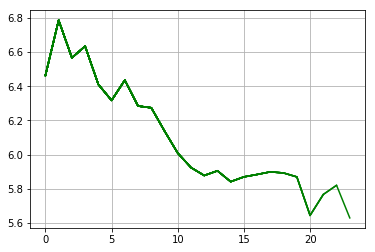

In [0]:
tf.reset_default_graph()
train()

In [0]:
tf.reset_default_graph()
test()

W0626 02:04:22.032955 140399172716416 rnn_cell_impl.py:697] <tensorflow.python.ops.rnn_cell_impl.BasicLSTMCell object at 0x7fb0d75abb00>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.
W0626 02:04:22.034357 140399172716416 rnn_cell_impl.py:697] <tensorflow.python.ops.rnn_cell_impl.BasicLSTMCell object at 0x7fb0d75abcc0>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.
/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py:1735: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


0 /content/gdrive/My Drive/Graduation Project/Different Feature Extractor Models/graduationFeatures/msvd1/shortPreprocessWithAmrFix/VGG-16(4096)/test/ZbzDGXEwtGc_6_15.npy
a plane is flying 

1 /content/gdrive/My Drive/Graduation Project/Different Feature Extractor Models/graduationFeatures/msvd1/shortPreprocessWithAmrFix/VGG-16(4096)/test/jbzaMtPYtl8_48_58.npy
two men are working out in a race 

2 /content/gdrive/My Drive/Graduation Project/Different Feature Extractor Models/graduationFeatures/msvd1/shortPreprocessWithAmrFix/VGG-16(4096)/test/04Gt01vatkk_248_265.npy
a woman is mixing ingredients in a bowl 

3 /content/gdrive/My Drive/Graduation Project/Different Feature Extractor Models/graduationFeatures/msvd1/shortPreprocessWithAmrFix/VGG-16(4096)/test/mFCf8lLXrUc_25_35.npy
a woman is peeling an <unk> 

4 /content/gdrive/My Drive/Graduation Project/Different Feature Extractor Models/graduationFeatures/msvd1/shortPreprocessWithAmrFix/VGG-16(4096)/test/6eokrw6_bjU_1_9.npy
a man is ridi

# Visualize

In [0]:
def display_video(vpath):
  vid = YouTubeVideo(vpath)
  return vid 

M_TP6UTrh30_343_358


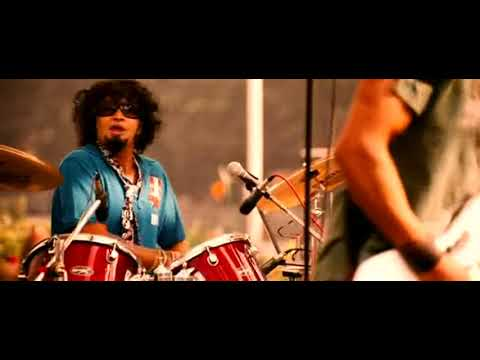

a band is playing for a large crowd

m1NR0uNNs5Y_57_64


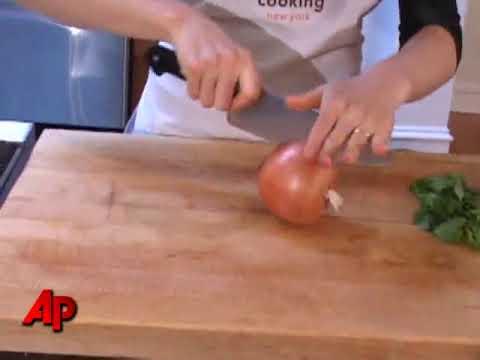

a woman is cutting an onion in half

4VLrxtf7Z_8_0_7


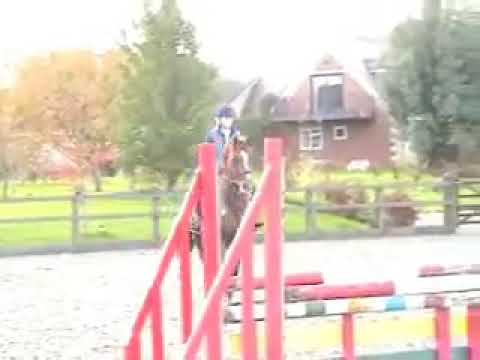

a horse and rider jumps over obstacles

WTf5EgVY5uU_15_19


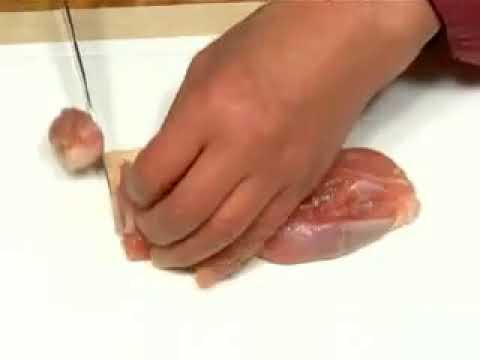

a woman is cutting a pork chop



In [0]:
with open("S2VT_results.txt", "r") as result_file:
   
    num_shows = 10
    
    youtube_list = {
       "4VLrxtf7Z_8_0_7" : "__bFiuU71rI",
       "WTf5EgVY5uU_15_19" : "0sliJH-2_D4",
       "m1NR0uNNs5Y_57_64" : "Duk2Yt47Lu8",
       "M_TP6UTrh30_343_358" : "3g6G82eIwEs"
    }
    
    for i in range(0,1904) :
      path = result_file.readline()
      split = path.split('/')
      file_id = split[len(split)-1].split(".avi")[0]
      description = result_file.readline()
      result_file.readline()
      
      
      if(file_id in youtube_list.keys()):
        print(file_id)
        display(display_video(youtube_list[file_id]))
        print(description)
      
      
      
      

# Evaluation

In [0]:
import os
import glob
import numpy as np
import pandas as pd
import pickle

In [0]:
#!git clone https://github.com/tylin/coco-caption.git
#!mv /content/coco-caption /content/cocoCap
#!/content/coco-caption/get_stanford_models.sh

#import cocoCap

#from cocoCap.pycocoevalcap.tokenizer.ptbtokenizer import PTBTokenizer
#from cocoCap.pycocoevalcap.bleu.bleu_scorer import BleuScorer
#from cocoCap.pycocotools.coco import COCO
#from cocoCap.pycocoevalcap.eval import COCOEvalCap

from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

## Generate the reference json file from ground truth CSV

In [0]:
video_data = pd.read_csv('/content/MSR Video Description Corpus.csv', sep=',')
video_data = video_data[video_data['Language'] == 'English']

videoID_lists = list(video_data['VideoID'])
videoID_start_lists = list(video_data['Start'])
videoID_end_lists = list(video_data['End'])
video_descriptions_lists = list(video_data['Description'])

videoID_with_Frames = []
for idx, item in enumerate(videoID_lists):
    temp = videoID_lists[idx] + '_' + str(int(videoID_start_lists[idx])) + '_' + str(int(videoID_end_lists[idx]))
    videoID_with_Frames.append(temp)

# videoID map
videoID_shrinked = list(set(videoID_with_Frames))

map_videoID = {}
for idx, item in enumerate(videoID_shrinked):
    map_videoID[idx] = item

with open('/content/map_videoID.pkl', 'wb') as f:
    pickle.dump(map_videoID, f)

In [0]:
def is_ascii(s):
    return all(ord(c) < 128 for c in s)

In [0]:
json_fd = open('/content/reference.json', 'w')
json_fd.write('{"info": {"description": "ground truth", "version": "1.0", "year": 2019, "date_created": "2019-03-17"}, "images": [')


tmp_idx = 1
for key in map_videoID:
    if tmp_idx != len(map_videoID):
        json_fd.write('{"license": 1, "file_name": "' + str(map_videoID[key]) + '", "id": ' + str(key) + '}, ')
    if tmp_idx == len(map_videoID):
        json_fd.write('{"license": 1, "file_name": "' + str(map_videoID[key]) + '", "id": ' + str(key) + '}], ')
    tmp_idx += 1

json_fd.write('"licenses": [{"url": "http://creativecommons.org/licenses/by-nc-sa/2.0/", "id": 1, "name": "Attribution-NonCommercial-ShareAlike License"}], ')
json_fd.write('"type": "captions", "annotations": [')

id_count = 0
for count, key in enumerate(map_videoID):
    video_frame = map_videoID[key]
    indices = [i for i, x in enumerate(videoID_with_Frames) if x == video_frame]
    if count != len(map_videoID)-1:
        for idx in indices:
            if type(video_descriptions_lists[idx]) == type(1.0):
                continue
        
            if '\\' in video_descriptions_lists[idx]:
                print (video_descriptions_lists[idx])
                continue

            if '"' in video_descriptions_lists[idx]:
                print (video_descriptions_lists[int(idx)])
                continue
        
            if "\n" in video_descriptions_lists[idx]:
                print (video_descriptions_lists[int(idx)])
                continue

            if is_ascii(video_descriptions_lists[idx]):
                json_fd.write('{"image_id": ' + str(key) + ', "id": ' + str(id_count) + ', "caption": "' + str(video_descriptions_lists[idx]) + '"}, ')
                id_count = id_count + 1

    if count == len(map_videoID)-1:
        for ii, idx in enumerate(indices):
            if type(video_descriptions_lists[idx]) == type(1.0):
                continue
        
            if '\\' in video_descriptions_lists[idx]:
                print (video_descriptions_lists[idx])
                continue
        
            if '"' in video_descriptions_lists[idx]:
                print (video_descriptions_lists[int(idx)])
                continue
        
            if "\n" in video_descriptions_lists[idx]:
                print (video_descriptions_lists[int(idx)])
                continue
            
            if ii != len(indices)-1:
                json_fd.write('{"image_id": ' + str(key) + ', "id": ' + str(id_count) + ', "caption": "' + str(video_descriptions_lists[idx]) + '"}, ')
                id_count = id_count + 1
            if ii == len(indices)-1:
                json_fd.write('{"image_id": ' + str(key) + ', "id": ' + str(id_count) + ', "caption": "' + str(video_descriptions_lists[idx]) + '"}]}')

json_fd.close()

The Tamil actors are singing song "Vennilave"
are you asking about the tune﻿ that starts? that would be "collumbus" sang by ar rahman from da film jeans
Lionel Richie is dancing in a video and ends up "dancing on the ceiling."
Somebody typing on "Dell" keyboard
Two girls are dancing to "Soldier Boy."
A fog monster occur"s
An episode of "I Love Lucy" where Desi lights Lucy a cigarette.
Guitar played by a professional in "Take me home"
A person is caring small animals on her ham\nds
Many people"s are dancing in the disco
A man clean another man"s shirt
"Oh! I cant be wet", says monkey.
RC Adventure of a small plane looks beautiful!
It sparks like an airforce force!
In this show of "Cooking with Jack" episode 32nd being "Pizza Wars" held at the cortina's Italian market & pizzeria the California dough was judged better than the Newyork dough.
A dog appears to be saying "I want my mama."
A dog barking "I want my mama".
this is 
Lazy Man's Pork Chops
The actual title of this film is "SHAOLIN

## Generate the results json file from Our Model Results

In [0]:
output = open('/content/S2VT_results.txt').read().splitlines()

num_all_output = len(output)

avi_names_lists = []
machine_produced_sentences = []

for idx, item in enumerate(output):
    if (idx % 3) == 0:
        avi_names_lists.append(item)
    if (idx % 3) == 1:
        machine_produced_sentences.append(item)

avi_npy_basenames = map(lambda item: os.path.basename(item), avi_names_lists)

avi_names = []
for each_avi in avi_npy_basenames:
    tmp1, tmp2, tmp3 = each_avi.split('.')
    avi_names.append(tmp1)

fd = open('/content/map_videoID.pkl', 'rb')
map_videoID = pickle.load(fd)

map_videoID_reverse = {}
for key in map_videoID:
    val = map_videoID[key]
    map_videoID_reverse[val] = key

json_fd = open('/content/generation.json', 'w')
json_fd.write('[')
for idx, item in enumerate(avi_names):
    if idx != len(avi_names)-1:
        json_fd.write('{"image_id": ' + str(map_videoID_reverse[item]) + ', "caption": "' + str(machine_produced_sentences[idx]) + '"}, ')
    if idx == len(avi_names)-1:
        json_fd.write('{"image_id": ' + str(map_videoID_reverse[item]) + ', "caption": "' + str(machine_produced_sentences[idx]) + '"}]')

json_fd.close()

## Evaluation Process

In [0]:
annFile = '/content/reference.json'
resFile = '/content/generation.json'

# create coco object and cocoRes object
coco = COCO(annFile)
cocoRes = coco.loadRes(resFile)

# create cocoEval object by taking coco and cocoRes
cocoEval = COCOeval(coco, cocoRes)

# evaluate on a subset of images by setting
# cocoEval.params['image_id'] = cocoRes.getImgIds()
# please remove this line when evaluating the full validation set
cocoEval.params['image_id'] = cocoRes.getImgIds()

# evaluate results
cocoEval.evaluate()

# print output evaluation scores
for metric, score in cocoEval.eval.items():
    print ('%s: %.3f'%(metric, score))

loading annotations into memory...
Done (t=0.10s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!


KeyError: ignored